In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools


def visualize_top_k_accuracy(accs):
    colors = itertools.cycle(['b', 'g', 'c', 'm', 'y', 'k'])

    for acc, name in accs:
        k, accuracy = zip(*acc)
        accuracy_percentage = [a * 100 for a in accuracy]  # Convert to percentage

        plt.plot(k, accuracy_percentage, color=next(colors))
        plt.xlabel('k')
        plt.ylabel('Top-k Accuracy (%)')
        plt.title('Top-k Accuracy')
        
        # Set y-axis limit to 0-100%
        # plt.ylim(50, 110)
        plt.xlim(0, 20)
        plt.xticks(range(int(min(k)), int(max(k)) + 1))

        # Add a horizontal red dashed line at 100%
    plt.axhline(y=100, color='r', linestyle='--', label='100% Accuracy')

    # Show the legend
    plt.legend([name for _, name in accs])

    # Display the plot
    # plt.grid(True)
    plt.show()


def topk_accuracy(df, max_k=100):
    temp = -1
    k_acc = []
    for k in range(1, max_k + 1):
        top_k_conditions = [(df[f'top{rank}_text'] == df['answer_text']) for rank in range(1, k + 1)]
        top_k_accuracy = (df['correct'] & pd.concat(top_k_conditions, axis=1).any(axis=1)).mean()
        if top_k_accuracy != temp:
            k_acc.append((k, top_k_accuracy))
            temp = top_k_accuracy
        if top_k_accuracy == 1.0:
            break
    else:
        # 루프가 100%에 도달하지 못했을 경우 마지막 accuracy
        k_acc.append((k, top_k_accuracy))
        
    return k_acc

        
def topk_accuracy_fixed(df, topk=[1, 2, 3, 5, 10], max_topk=(len(df.columns) - 3) // 2):
    k_acc = []
    for k in range(1, max_topk + 1):
        # 각 k에 대해 모든 row에 대해 top_k 조건을 계산
        top_k_conditions = [(df[f'top{rank}_text'] == df['answer_text']) for rank in range(1, k + 1)]
        top_k_accuracy = (df['correct'] & pd.concat(top_k_conditions, axis=1).any(axis=1)).mean()

        # topk 리스트에 있는 값이 나오면 k_acc에 추가
        if k in topk:
            k_acc.append((k, top_k_accuracy))

        # top_k_accuracy가 1.0이면 k_acc에 추가하고 루프 종료
        if top_k_accuracy == 1.0:
            k_acc.append((k, top_k_accuracy))
            break

    return k_acc


def update_correct_column(df, k):
    # correct 열을 업데이트할 새로운 리스트를 만듦
    df = df.copy()
    updated_correct = []
    
    for idx, row in df.iterrows():
        found_correct = False
        
        # top-k 범위 내에서 answer_text와 일치하는지 확인
        for rank in range(1, k + 1):
            if row[f'top{rank}_text'] == row['answer_text']:
                found_correct = True
                break
        
        # 맞춘 경우 'correct', 아니면 'false' 추가
        if found_correct:
            updated_correct.append('correct')
        else:
            updated_correct.append('false')
    
    # correct 열 업데이트
    df['correct'] = updated_correct
    df_false = df[df['correct'] == 'false']
    
    return df_false


def print_false_answers(df, print_k=5):
    for idx, row in df.iterrows():
        print(f"query: {row['query']}")
        print(f"answer: {row['answer_text']}")
        print()
        for k in range(1, print_k + 1):
            print(f"top {k}: {row[f'top{k}_text'][:200]}")        
        print()
        print()

In [35]:
e5_mistral = pd.read_csv('../data/experiments/e5-mistral_topn.csv')
mul_e5_max = pd.read_csv('../data/experiments/multilang-e5_max_pooling.csv')
mul_e5_mean = pd.read_csv('../data/experiments/multilang-e5_mean_pooling.csv')
koe5_mean = pd.read_csv('../data/experiments/KoE5_mean_pooling.csv')
koe5_max = pd.read_csv('../data/experiments/KoE5_max_pooling.csv')

In [43]:
# calculate_top_k_accuracy(df, max_k=10)
k_acc = topk_accuracy_fixed(koe5_max, topk=[1,2,3,5,10])
for k, acc in k_acc:
    print(f"Top {k} Accuracy: {acc * 100:.2f} %")

Top 1 Accuracy: 96.00 %
Top 2 Accuracy: 96.00 %
Top 3 Accuracy: 98.00 %
Top 5 Accuracy: 98.00 %
Top 7 Accuracy: 100.00 %


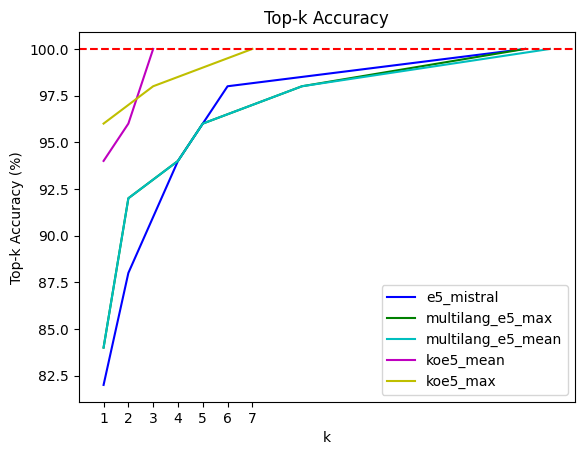

In [37]:
accs = [(topk_accuracy(e5_mistral), 'e5_mistral'),
        (topk_accuracy(mul_e5_max), 'multilang_e5_max'),
        (topk_accuracy(mul_e5_mean), 'multilang_e5_mean'),
        (topk_accuracy(koe5_mean), 'koe5_mean'),
        (topk_accuracy(koe5_max), 'koe5_max'),
        ]
visualize_top_k_accuracy(accs)

In [38]:
# top k 안에 정답을 못찾은 dataframe을 반환
k = 1  
df_false_top_n = update_correct_column(df, k=k)  # k 값을 원하는 대로 설정
print(f" False count: {df_false_top_n.shape[0]}")
print("Printing False Answers")
print_false_answers(df_false_top_n, print_k=5)  # k 값을 원하는 대로 설정

 False count: 8
Printing False Answers
query: 샤 슈자가 자신의 왕위를 물려줄 사람은?
answer: 무자파르 왕국은 1335년부터 1393년까지 현재의 이란 중부에 존재했던 국가이다. 1335년 일 한국의 아부 사이드 칸이 죽자 야즈드의 세력가인 무바라즈 알딘에 의해 세워졌다. 무바리즈 알딘은 동쪽으로는 케르만을 점령하고 서쪽으로는 인주 왕조를 멸망시켜 국토를 크게 넓혔다. 하지만 무바라즈 알딘은 잔인한 성격으로 인해 인심을 잃어 1358년에 아들인 샤 슈자에게 붙잡힌 뒤 눈이 먼 채로 투옥되고 말았다.\n\n무바라즈 알딘에 이어 즉위한 샤 슈자는 자라이르 왕조의 우웨이스 1세의 지원을 받은 형제 샤 마흐무트와 대립을 벌였다. 샤 마흐무트는 오랜 기간 동안 세력을 유지했지만 1375년에 병사하고 말았다. 샤 슈자는 이 기회를 놓치지 않고 샤 마흐무트의 근거지였던 이스파한을 점령하고 그를 지원한 자라이르 왕조의 수도 타브리즈까지 점령하여 위세를 떨쳤지만 조카인 샤 야흐야(Shah Yhaya)의 반란 때문에 타브리즈를 포기해야 했다. 그로부터 9년 뒤인 1384년 샤 슈자는 죽기 전에 자신의 아들인 자인 알아비딘(Zain Al-Abidin)을 후계자로 임명하면서 티무르에게 충성 서약을 하게 하였다.\n\n샤 슈자에 이어 즉위한 자인 알아비딘은 즉위하자마자 티무르에게 한 충성 서약을 무시해버렸다. 이에 티무르는 군대를 일으켜 자인 알아비딘의 영토로 진격하였다. \n 이 소식을 들은 자인 알아비딘은 도망치다가 샤 야흐야의 형제인 샤 만수르(Shah Mansur)에게 사로잡혀 투옥되었다.자인 알아비딘이 잡히자 티무르는 샤 야흐야, 샤 만수르를 비롯한 무자파르 왕조의 지배자들을 불러 충성 서약을 받고 본국으로 돌아갔다. 티무르가 돌아간 이후 탈옥한 자인 알아비딘을 포함한 무자파르 왕조의 각 지배자들은 내분을 벌이기 시작했으며 샤 만수르가 이마드 앗딘을 투옥시키며 우위에 섰다.\n\n샤 만수르의 세력이 커지는 것을 본 티무르는 1393